<a href="https://colab.research.google.com/github/kirankamatmgm/FlowerImageClassifier/blob/master/FlowerspeciesClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to use the [Oxford 102 Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) by [Nilsback,M-E and Zisserman, A., 2008](http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.pdf). A 102 category dataset consisting of 102 flower categories, commonly occuring in the United Kingdom. Each class consists of 40 to 258 images. The images have large scale, pose and light variations.

Credits: fastai(for inspiring to do this project and ofcourse Im using fastai library)

To understand details about all basic code see my [1st Project](https://kirankamath.netlify.app/blog/image-classification-fast-ai/)

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import *

In [0]:
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [6]:
path=untar_data(URLs.FLOWERS)

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-102-flowers/test.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/valid.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/train.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg')]

In [0]:
path_img=path/'jpg'

This dataset is has train test and validation data in text file and images in jpg file. So using pandas dataframe looks good here

In [9]:
trn=pd.read_csv(path/'train.txt',sep=" ",header=None)
val=pd.read_csv(path/'valid.txt',sep=" ",header=None)
tst=pd.read_csv(path/'test.txt',sep=" ",header=None)
df = trn.append(val,ignore_index=True).append(tst,ignore_index=True)
df.columns=['Img','Class']
df.index=df.Img
df.head()

,Img,Class
Img,,
jpg/image_03860.jpg,jpg/image_03860.jpg,16
jpg/image_06092.jpg,jpg/image_06092.jpg,13
jpg/image_02400.jpg,jpg/image_02400.jpg,42
jpg/image_02852.jpg,jpg/image_02852.jpg,55
jpg/image_07710.jpg,jpg/image_07710.jpg,96


In [10]:
len(trn), len(val), len(tst)

(1020, 1020, 6149)

We have images with format jpg/{some name}.jpg and class label. But we dont know the name of flower. So to know name of flower, we have 2 steps.
1.   create a dictionary and add it manually seeing dataset website, or use content.json available with label and flower name
2.   Use web scrapping to extract images name. 

2nd option looks good, since it opportunity to learn web scrapping. 
I am using BeautifulSoup



In [0]:
from bs4 import BeautifulSoup
import re

In [12]:
url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html'
r= requests.get(url)

soup=BeautifulSoup(r.content, "lxml")
ims=soup.findAll('img')
print(ims)

[<img alt="alpine sea holly" border="0" height="75" src="thumbs/thumbim_06974.jpg" width="78"/>, <img alt="buttercup" border="0" height="76" src="thumbs/thumbim_04657.jpg" width="75"/>, <img alt="fire lily" border="0" height="75" src="thumbs/thumbim_06779.jpg" width="75"/>, <img alt="anthurium" border="0" height="75" src="thumbs/thumbim_02011.jpg" width="76"/>, <img alt="californian poppy" border="0" height="75" src="thumbs/thumbim_03206.jpg" width="76"/>, <img alt="foxglove" border="0" height="75" src="thumbs/thumbim_07419.jpg" width="80"/>, <img alt="artichoke" border="0" height="75" src="thumbs/thumbim_04093.jpg" width="80"/>, <img alt="camellia" border="0" height="75" src="thumbs/thumbim_07652.jpg" width="75"/>, <img alt="frangipani" border="0" height="76" src="thumbs/thumbim_00784.jpg" width="75"/>, <img alt="azalea" border="0" height="75" src="thumbs/thumbim_03581.jpg" width="75"/>, <img alt="canna lily" border="0" height="75" src="thumbs/thumbim_04479.jpg" width="75"/>, <img alt

Observe the content of ims carefully. It has img tag, in which we are interested in src and alt tag.
alt tag content label names, and src content details which we have in dataframe Img part.
so using this we can change df such that jpg/{something}.jpg is equal to label names

In [13]:
sample = {}
for im in ims[0:]:
    sample[f"jpg/image_{im['src'].split('_')[-1]}"] = im['alt']
len(sample.keys()), {k: sample[k] for k in list(sample)[:5]}

(102,
 {'jpg/image_02011.jpg': 'anthurium',
  'jpg/image_03206.jpg': 'californian poppy',
  'jpg/image_04657.jpg': 'buttercup',
  'jpg/image_06779.jpg': 'fire lily',
  'jpg/image_06974.jpg': 'alpine sea holly'})

We can see that its showing 102 keys means that we have scraped 102 image lables. There are 102 labels.

But actually we want dictionary that contains class label number to name mapping, so lets do that

In [14]:
names = {}
for im in sample.keys():
  names[df.loc[im]['Class']]=sample[im]

{k: names[k] for k in list(names)[:5]}

{20: 'fire lily',
 34: 'alpine sea holly',
 47: 'buttercup',
 64: 'californian poppy',
 79: 'anthurium'}

Go through the labels once


In [15]:
{k: names[k] for k in list(names)}

{0: 'pink primrose',
 1: 'hard-leaved pocket orchid',
 2: 'canterbury bells',
 3: 'sweet pea',
 4: 'english marigold',
 5: 'tiger lily',
 6: 'moon orchid',
 7: 'bird of paradise',
 8: 'monkshood',
 9: 'globe thistle',
 10: 'snapdragon',
 11: "colt's foot",
 12: 'king protea',
 13: 'spear thistle',
 14: 'yellow iris',
 15: 'globe-flower',
 16: 'purple coneflower',
 17: 'peruvian lily',
 18: 'balloon flower',
 19: 'giant white arum lily',
 20: 'fire lily',
 21: 'pincushion flower',
 22: 'fritillary',
 23: 'red ginger',
 24: 'grape hyacinth',
 25: 'corn poppy',
 26: 'prince of wales feathers',
 27: 'stemless gentian',
 28: 'artichoke',
 29: 'sweet william',
 30: 'carnation',
 31: 'garden phlox',
 32: 'love in the mist',
 33: 'mexican aster',
 34: 'alpine sea holly',
 35: 'ruby-lipped cattleya',
 36: 'cape flower',
 37: 'great masterwort',
 38: 'siam tulip',
 39: 'lenten rose',
 40: 'barbeton daisy',
 41: 'daffodil',
 42: 'sword lily',
 43: 'poinsettia',
 44: 'bolero deep blue',
 45: 'wall

In [16]:
codes = np.array([names[i] for i in range(len(names))]); codes

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', ..., 'bromelia',
       'blanket flower', 'trumpet creeper', 'blackberry lily'], dtype='<U25')

Here many labels contain space in between so lets remove that

In [0]:
trn[trn.columns[-1]] = trn[trn.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))
val[val.columns[-1]] = val[val.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))
tst[tst.columns[-1]] = tst[tst.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))

In [18]:
trn[:5]

,0,1
0,jpg/image_03860.jpg,purple_coneflower
1,jpg/image_06092.jpg,spear_thistle
2,jpg/image_02400.jpg,sword_lily
3,jpg/image_02852.jpg,bishop_of_llandaff
4,jpg/image_07710.jpg,mallow


Once confirmed all labels doesnot contain space move forward

In [19]:
fnames= get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_00529.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_00328.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_07095.jpg')]

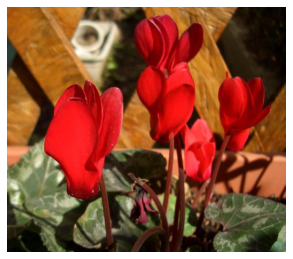

In [20]:
img_f = fnames[0]
img=open_image(img_f)
img.show(figsize=(5,5))

In [0]:
src_size = min(img.size)

In [0]:
size=src_size//2
bs=4

In [0]:
trnList = ImageList.from_df(df=trn, path=path)
valList = ImageList.from_df(df=val, path=path)
tstList = ImageList.from_df(df=tst, path=path)

In [0]:
src = (ImageList.from_folder(path).split_by_list(trnList,valList).label_from_df())

To know more about the above steps see [this](https://docs.fast.ai/data_block.html#ItemList.label_from_df) because it would take lot to explain everything so linking to docs of fastai

In [0]:
data = (src.transform(get_transforms(),size=size).databunch(bs=bs).normalize(imagenet_stats))

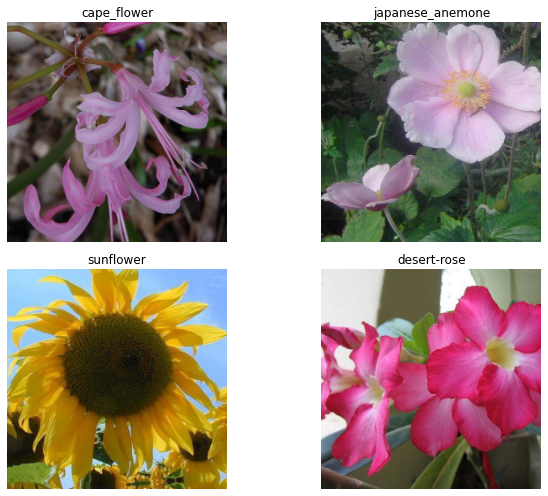

In [26]:
data.show_batch(4, figsize=(10,7))

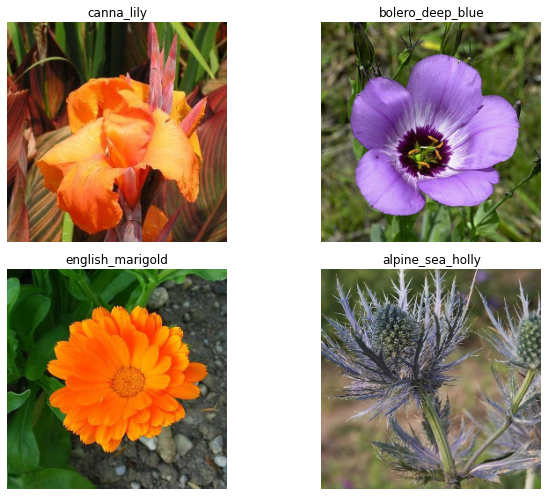

In [27]:
data.show_batch(4,figsize=(10,7),ds_type=DatasetType.Valid)

In [0]:
metrics=accuracy

In [29]:
learn=cnn_learner(data,models.resnet34,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Downloaded pretrained weights and using resnet34 which is trained on imagenet. You can try vgg, resnet50 also. Resnet 50 is best and can get better accuracy, I am not doing it, because of my space and time limitation

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


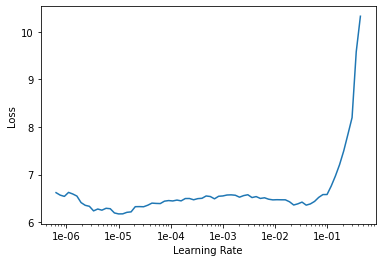

In [30]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy,time
0,6.156984,4.590524,0.046078,00:30
1,5.120844,3.424721,0.224510,00:30
2,3.638896,2.221143,0.484314,00:30
3,2.891678,1.523283,0.636275,00:30
4,2.325167,1.261948,0.686275,00:30
5,2.097249,1.228347,0.677451,00:30
6,1.986707,1.102566,0.711765,00:30
7,2.222347,1.115762,0.701961,00:30
8,1.909852,0.974875,0.743137,00:30
9,1.473234,0.843119,0.775490,00:31


In [0]:
learn.save('stage-1')

This is very important step since if wanting to experiment with different learning rate and other hyperparametes, its important to save so that we can load when needed

In [34]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1020 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
purple_coneflower,spear_thistle,sword_lily,bishop_of_llandaff,mallow
Path: /root/.fastai/data/oxford-102-flowers;

Valid: LabelList (1020 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
canna_lily,bolero_deep_blue,english_marigold,alpine_sea_holly,anthurium
Path: /root/.fastai/data/oxford-102-flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_

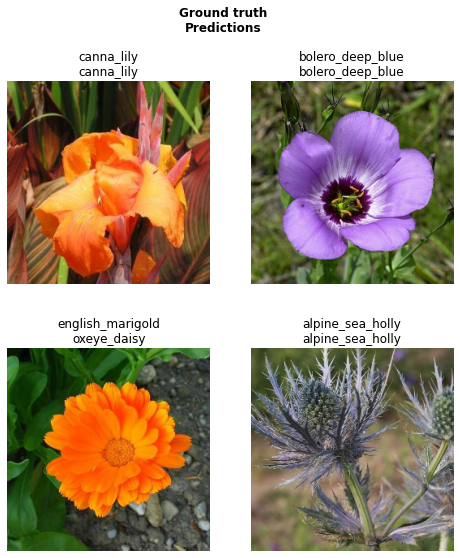

In [35]:
learn.show_results(rows=4,figsize=(8,9))

This step is important since it shows which images we have correctly classified and which we did not

In [0]:
learn.unfreeze()

Unfreezes entire model, sets every layer group to train.

In [0]:
lrs= slice(lr/400,lr/4)

In [38]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.334105,0.783806,0.792157,00:32
1,1.233995,0.741752,0.798039,00:32
2,1.197076,0.674116,0.812745,00:33
3,1.094136,0.634781,0.842157,00:33
4,0.956022,0.625526,0.830392,00:34
5,1.114396,0.587442,0.838235,00:33
6,1.179830,0.584663,0.834314,00:33
7,1.264932,0.692555,0.819608,00:32
8,1.135185,0.599189,0.844118,00:33
9,1.128613,0.652868,0.841176,00:33


In [0]:
learn.save('stage-2')

As you can see accuracy has increased compared to stage 1 so save this

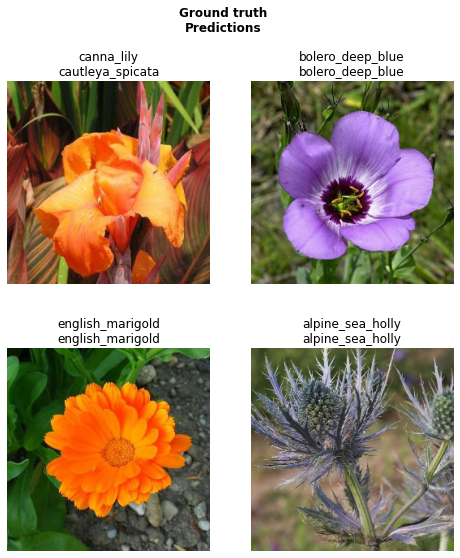

In [40]:
learn.show_results(ds_type=DatasetType.Valid, rows=4,figsize=(8,9))

In [0]:
learn.export()

In [0]:
src2 = (ImageList.from_folder(path)
       .split_by_list(trnList, tstList)
       .label_from_df()
       )
data2 = (src2.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn2 = cnn_learner(data2, models.resnet34, metrics=metrics)
learn2.load('stage-2');

In [43]:
preds,y,losses = learn2.get_preds(with_loss=True)
accuracy(preds,y)

tensor(0.8452)

In [44]:
len(trn), len(val),len(tst)

(1020, 1020, 6149)

In [0]:
bs = 8
size = src_size
metrics=accuracy

In [0]:
src3 = (ImageList.from_df(df=trn.append(tst, ignore_index=True), path=path)
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_df()
       )
data3 = (src3.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data3, models.resnet34, metrics=metrics)

In [47]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (5736 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
purple_coneflower,spear_thistle,sword_lily,bishop_of_llandaff,mallow
Path: /root/.fastai/data/oxford-102-flowers;

Valid: LabelList (1433 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
pink-yellow_dahlia?,daffodil,purple_coneflower,watercress,bolero_deep_blue
Path: /root/.fastai/data/oxford-102-flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kern

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


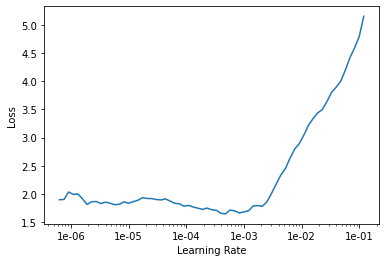

In [49]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=5e-4

In [0]:
lrs=slice(1e-5,lr/10)

In [52]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,accuracy,time
0,1.384226,0.477209,0.879274,04:34
1,0.818306,0.230950,0.943475,04:35
2,0.518546,0.167983,0.956036,04:35
3,0.387305,0.140578,0.968597,04:36
4,0.300006,0.115997,0.972087,04:33
5,0.240830,0.093787,0.981158,04:35
6,0.187486,0.090038,0.977669,04:37
7,0.109384,0.084203,0.983252,04:40
8,0.143494,0.085302,0.981158,04:37
9,0.151969,0.083969,0.981158,04:33


In [0]:
learn.save('stage-3')

In [0]:
learn.export()

In [0]:
src2 = (ImageList.from_folder(path)
       .split_by_list(trnList, valList)
       .label_from_df()
       )
data2 = (src2.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn2 = cnn_learner(data2, models.resnet34, metrics=metrics)
learn2.load('stage-3');

In [56]:
preds,y,losses = learn2.get_preds(with_loss=True)
accuracy(preds,y)

tensor(0.9784)

I got accuracy of 97.84%